##1.Run sensor fusion excercises on waymo dataset

from github: https://github.com/udacity/nd013-c2-fusion-exercises




In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


##Import libraries

In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/GoogleColab/lib')
libs_path = '/content/gdrive/MyDrive/GoogleColab/lib'
%cd $libs_path

/content/gdrive/MyDrive/GoogleColab/lib


In [ ]:
# general package imports
import os
import sys
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import copy
import zlib
from easydict import EasyDict as edict

## Set my paths

In [ ]:
path = '/content/gdrive/MyDrive/GoogleColab'
udacity_path = path + '/UDACITY'
sdc_path = udacity_path + '/SDC'
project_path = sdc_path + '/2-waymo-sensor-fusion'


#Google drive
data_path = project_path + '/data'
waymo_path = data_path + '/waymo'
ex_dir = waymo_path + '/exercises/'

#Github clone
folder_path = project_path + '/Udacity-waymo-sensorfusion-exercises'
exe_L1_path = folder_path + '/lesson-1-lidar-sensor/exercises/solution'
exa_L1_path = folder_path + '/lesson-1-lidar-sensor/examples'
exe_L2_path = folder_path + '/lesson-2-object-detection/exercises/solution'
exa_L2_path = folder_path + '/lesson-2-object-detection/examples'

results_path = folder_path + '/results'

In [ ]:
sys.path.append(exe_L1_path)
sys.path.append(exa_L1_path)
sys.path.append(exe_L2_path)
sys.path.append(exa_L2_path)
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/MyDrive/GoogleColab/lib',
 '/content/gdrive/MyDrive/GoogleColab/UDACITY/SDC/2-waymo-sensor-fusion/Udacity-waymo-sensorfusion-exercises/lesson-1-lidar-sensor/exercises/solution',
 '/content/gdrive/MyDrive/GoogleColab/UDACITY/SDC/2-waymo-sensor-fusion/Udacity-waymo-sensorfusion-exercises/lesson-1-lidar-sensor/examples',
 '/content/gdrive/MyDrive/GoogleColab/UDACITY/SDC/2-waymo-sensor-fusion/Udacity-waymo-sensorfusion-exercises/lesson-2-object-detection/exercises/solution',
 '/content/gdrive/MyDrive/GoogleColab/UDACITY/SDC/2-waymo-sensor-fusion/Udacity-waymo-sensorfusion-exercises/lesson-2-object-detection/examples']

In [ ]:
# Waymo open dataset reader
%cd $project_path
from tools.waymo_reader.simple_waymo_open_dataset_reader import WaymoDataFileReader, dataset_pb2, label_pb2
from tools.waymo_reader.simple_waymo_open_dataset_reader import utils as waymo_utils

/content/gdrive/MyDrive/GoogleColab/UDACITY/SDC/2-waymo-sensor-fusion


In [ ]:
# misc. project-related imports
%cd $folder_path
import misc.objdet_tools as tools
from misc.helpers import load_object_from_file

/content/gdrive/MyDrive/GoogleColab/UDACITY/SDC/2-waymo-sensor-fusion/Udacity-waymo-sensorfusion-exercises


## Import functions from exercises

In [ ]:
#install open3d

#!pip install --target=$libs_path pip>=20.3 --upgrade
#!pip install --target=$libs_path open3d --upgrade

In [ ]:
import open3d

In [ ]:
!git pull

Already up to date.


In [ ]:
# import functions from individual exercise files
import l1_examples
import l1_exercises
import l2_examples
import l2_exercises

# Set parameters and perform initializations

In [23]:
data_filename = 'training_segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord' # Sequence 1
#data_filename = 'training_segment-10072231702153043603_5725_000_5745_000_with_camera_labels.tfrecord' # Sequence 2
# data_filename = 'training_segment-10963653239323173269_1924_000_1944_000_with_camera_labels.tfrecord'  # Sequence 3

show_only_frames = [0, 10]  # show only frames in interval for debugging

# set pause time between frames in ms (0 = stop between frames until key is pressed)
vis_pause_time = 0  

## Prepare waymo dataset file for loading

In [ ]:
data_fullpath = ex_dir + data_filename
#results_fullpath = os.path.join(os.path.dirname(os.path.realpath(__file__)), 'results')
datafile = WaymoDataFileReader(data_fullpath)
datafile_iter = iter(datafile)  # initialize dataset iterator

## L1.examples


Google colab doesn't support infinite visualization via o3d.visualizaion.draw_geometries
I had to modify the code in order to visualize it via Ploty

see: https://colab.research.google.com/drive/1CR_HDvJ2AnjJV3Bf5vwP70K0hx3RcdMb?usp=sharing#scrollTo=ha6Mm4lbDq6k

In [ ]:
import plotly.graph_objects as go

In [ ]:
# Example C1-5-6 : Convert range image to 3D point-cloud
import open3d as o3d

def load_range_image(frame, lidar_name):
    
    lidar = [obj for obj in frame.lasers if obj.name == lidar_name][0] # get laser data structure from frame
    ri = []
    if len(lidar.ri_return1.range_image_compressed) > 0: # use first response
        ri = dataset_pb2.MatrixFloat()
        ri.ParseFromString(zlib.decompress(lidar.ri_return1.range_image_compressed))
        ri = np.array(ri.data).reshape(ri.shape.dims)
    return ri

def range_image_to_point_cloud(frame, lidar_name, vis=True):

    # extract range values from frame
    ri = load_range_image(frame, lidar_name)
    ri[ri<0]=0.0
    ri_range = ri[:,:,0]

    # load calibration data
    calibration = [obj for obj in frame.context.laser_calibrations if obj.name == lidar_name][0]

    # compute vertical beam inclinations
    height = ri_range.shape[0]
    inclination_min = calibration.beam_inclination_min
    inclination_max = calibration.beam_inclination_max
    inclinations = np.linspace(inclination_min, inclination_max, height)
    inclinations = np.flip(inclinations)

    # compute azimuth angle and correct it so that the range image center is aligned to the x-axis
    width = ri_range.shape[1]
    extrinsic = np.array(calibration.extrinsic.transform).reshape(4,4)
    az_correction = math.atan2(extrinsic[1,0], extrinsic[0,0])
    azimuth = np.linspace(np.pi,-np.pi,width) - az_correction

    # expand inclination and azimuth such that every range image cell has its own appropriate value pair
    azimuth_tiled = np.broadcast_to(azimuth[np.newaxis,:], (height,width))
    inclination_tiled = np.broadcast_to(inclinations[:,np.newaxis],(height,width))

    # perform coordinate conversion
    x = np.cos(azimuth_tiled) * np.cos(inclination_tiled) * ri_range
    y = np.sin(azimuth_tiled) * np.cos(inclination_tiled) * ri_range
    z = np.sin(inclination_tiled) * ri_range

    # transform 3d points into vehicle coordinate system
    xyz_sensor = np.stack([x,y,z,np.ones_like(z)])
    xyz_vehicle = np.einsum('ij,jkl->ikl', extrinsic, xyz_sensor)
    xyz_vehicle = xyz_vehicle.transpose(1,2,0)

    # extract points with range > 0
    idx_range = ri_range > 0
    pcl = xyz_vehicle[idx_range,:3]
 
    print('visualize point-cloud')
    if vis:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pcl)
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
        o3d.visualization.draw_geometries = draw # replace function
        o3d.visualization.draw_geometries([pcd])

    # stack lidar point intensity as last column
    pcl_full = np.column_stack((pcl, ri[idx_range, 1]))    

    return pcl_full    


def draw(geometries):
    graph_obj = []

    for gm in geometries:
        geometry_type = gm.get_geometry_type()
        
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            pts = np.asarray(gm.points)
            clr = None  #for colors
            if gm.has_colors():
                clr = np.asarray(gm.colors)
            elif gm.has_normals():
                clr = (0.5, 0.5, 0.5) + np.asarray(gm.normals) * 0.5
            else:
                gm.paint_uniform_color((1.0, 0.0, 0.0))
                clr = np.asarray(gm.colors)

            sc = go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2], mode='markers', marker=dict(size=1, color=clr))
            graph_obj.append(sc)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            tri = np.asarray(gm.triangles)
            vert = np.asarray(gm.vertices)
            clr = None
            if gm.has_triangle_normals():
                clr = (0.1, 0.3, 0.5) + np.asarray(gm.triangle_normals) * 0.5
                clr = tuple(map(tuple, clr))
            else:
                clr = (1.0, 0.0, 0.0)
            
            mesh = go.Mesh3d(x=vert[:,0], y=vert[:,1], z=vert[:,2], i=tri[:,0], j=tri[:,1], k=tri[:,2], facecolor=clr, opacity=0.50)
            graph_obj.append(mesh)
        
    fig = go.Figure(
        data=graph_obj,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

## Run exercises


I had to modify the cv2.imshow to cv2_imshow prebuilt google colab patch to opencv in order to display the images

In [ ]:
##################
# Perform detection & tracking over all selected frames

cnt_frame = 0
det_performance_all = []  # used for exercises in C2-4
while True:
    try:
        #################################
        # Get next frame from Waymo dataset

        frame = next(datafile_iter)
        if cnt_frame < show_only_frames[0]:
            cnt_frame = cnt_frame + 1
            continue
        elif cnt_frame > show_only_frames[1]:
            print('reached end of selected frames')
            break

        print('------------------------------')
        print('processing frame #' + str(cnt_frame))

        # Usage instruction : When working on a specific exercise, 
        # simply uncomment the respective function calls and open 
        # the implementation for more details

        ####### LESSON 1 EXERCISES & EXAMPLES START #######
        #######

        lidar_name = dataset_pb2.LaserName.TOP

        # Exercise C1-3-1 : print no. of vehicles
        l1_exercises.print_no_of_vehicles(frame) 
        #print_no_of_vehicles(frame) 
        
        # Example C1-3-2 : display camera image
        l1_examples.display_image(frame)

        # Example C1-3-3 : print angle of vertical field of view
        l1_examples.print_vfov_lidar(frame, lidar_name)

        # Example C1-5-1 : Load range image
        l1_examples.print_range_image_shape(frame, lidar_name)
        #print_range_image_shape(frame, lidar_name)

        # Exercise C1-5-2 : Compute pitch angle resolution
        l1_exercises.print_pitch_resolution(frame, lidar_name)
        #print_pitch_resolution(frame, lidar_name)
        

        # Example C1-5-3 : Retrieve maximum and minimum distance
        l1_examples.get_max_min_range(frame, lidar_name)
        #get_max_min_range(frame, lidar_name)

        # Example C1-5-4 : Visualize range channel
        l1_examples.vis_range_channel(frame, lidar_name)
        #vis_range_channel(frame, lidar_name)

        # Exercise C1-5-5 : Visualize intensity channel
        l1_exercises.vis_intensity_channel(frame, lidar_name)
        #vis_intensity_channel(frame, lidar_name)

        # Example C1-5-6 : Convert range image to 3D point-cloud
        #l1_examples.range_image_to_point_cloud(frame, lidar_name)
        range_image_to_point_cloud(frame, lidar_name)

        #######
        ####### LESSON 1 EXERCISES & EXAMPLES  END #######


        ####### LESSON 2 EXERCISES & EXAMPLES  START #######
        #######

        # Define parameters used in subsequent steps
        configs = edict()
        configs.lim_x = [0, 50]
        configs.lim_y = [-25, 25]
        configs.lim_z = [-0.3, 3]
        configs.bev_width = 608
        configs.bev_height = 608
        configs.conf_thresh = 0.5
        configs.model = 'darknet'

        # Example C2-3-1 : Crop point cloud
        lidar_pcl = l1_examples.range_image_to_point_cloud(frame, lidar_name, True)
        cropped_pcl = l2_examples.crop_pcl(lidar_pcl, configs, False)

        # Exercise C2-3-2 : Transform metric point coordinates to BEV space
        l2_exercises.pcl_to_bev(cropped_pcl, configs)

        # Example C2-3-3 : Minimum and maximum intensity
        l2_examples.min_max_intensity(lidar_pcl)

        # Example C2-4-2 : count total no. of vehicles and vehicles that are difficult to track
        l2_examples.count_vehicles(frame)

        # Example C2-4-3 : Display label bounding boxes on top of BEV map 
        lidar_bev = load_object_from_file(results_path, data_filename, 'lidar_bev', cnt_frame)
        lidar_bev_labels = l2_examples.render_bb_over_bev(lidar_bev, frame.laser_labels, configs)

        # Example C2-4-4 : Display detected objects on top of BEV map
        detections = load_object_from_file(results_path, data_filename, 'detections_' + configs.model + '_' + str(configs.conf_thresh), cnt_frame)
        l2_examples.render_obj_over_bev(detections, lidar_bev_labels, configs, True)

        # Exercise C2-4-5 : Compute precision and recall (part 1/2 - remove comments only, no action inside functions required)
        #det_performance = load_object_from_file(results_path, data_filename, 'det_performance_' + configs.model + '_' + str(configs.conf_thresh), cnt_frame)
        #det_performance_all.append(det_performance)  # store all evaluation results in a list for performance assessme

        #######
        ####### LESSON 2 EXERCISES & EXAMPLES  END #######

        # increment frame counter
        cnt_frame = cnt_frame + 1

    except StopIteration:
        # if StopIteration is raised, break from loop
        break

    # Exercise C2-4-5 : Compute precision and recall (part 2/2)
    #l2_exercises.compute_precision_recall(det_performance_all)

    # Exercise C2-4-6 : Plotting the precision-recall curve
    #l2_exercises.plot_precision_recall()


Output hidden; open in https://colab.research.google.com to view.

## Plot precision and recall for various thresholds on results .pkl files

THRESHOLD:  0.1
TP = 20, FP = 6, FN = 0
precision = 0.7692307692307693, recall = 1.0, conf_thres = 0.1

THRESHOLD:  0.2
TP = 20, FP = 5, FN = 0
precision = 0.8, recall = 1.0, conf_thres = 0.2

THRESHOLD:  0.3
TP = 20, FP = 5, FN = 0
precision = 0.8, recall = 1.0, conf_thres = 0.3

THRESHOLD:  0.4
TP = 20, FP = 5, FN = 0
precision = 0.8, recall = 1.0, conf_thres = 0.4

THRESHOLD:  0.5
TP = 20, FP = 5, FN = 0
precision = 0.8, recall = 1.0, conf_thres = 0.5

THRESHOLD:  0.6
TP = 20, FP = 4, FN = 0
precision = 0.8333333333333334, recall = 1.0, conf_thres = 0.6

THRESHOLD:  0.7
TP = 20, FP = 4, FN = 0
precision = 0.8333333333333334, recall = 1.0, conf_thres = 0.7

THRESHOLD:  0.8
TP = 20, FP = 4, FN = 0
precision = 0.8333333333333334, recall = 1.0, conf_thres = 0.8

THRESHOLD:  0.9
TP = 20, FP = 1, FN = 0
precision = 0.9523809523809523, recall = 1.0, conf_thres = 0.9

Precision and recall for different thresholds


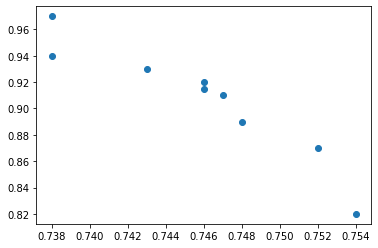

In [42]:
thresholds = [x/10 for x in range(1, 10)]
det_performance_all = []  # used for exercises in C2-4
for threshold in thresholds:
  det_performance_all = []
  cnt_frame = 10
  while cnt_frame>0:

      # Exercise C2-4-5 : Compute precision and recall (part 1/2 - remove comments only, no action inside functions required)
      det_performance = load_object_from_file(results_path, data_filename, 'det_performance_' + configs.model + '_' + str(threshold), cnt_frame)
      det_performance_all.append(det_performance)  # store all evaluation results in a list for performance assessme
      # increment frame counter
      cnt_frame = cnt_frame - 1

  print("THRESHOLD: ", threshold)
  # Exercise C2-4-5 : Compute precision and recall (part 2/2)
  l2_exercises.compute_precision_recall(det_performance_all, threshold)

# Exercise C2-4-6 : Plotting the precision-recall curve
print("Precision and recall for different thresholds")
l2_exercises.plot_precision_recall()
